In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [182]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import multiprocessing as mpp
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
from hpc_lib import *
#
import pandas

In [299]:

#
# get header, print a few rows:
#data_file_name = 'data/sacct_out.out'
#data_file_name = 'data/sacct_mazama_out.out'
data_file_name = 'data/sacct_sherlock_out_hns.out'
#data_file_name = 'data/sacct_sherlock_out_oneillm.out'
#
demo_file = 'data/demo_data.out'
with open(data_file_name, 'r') as fin:
    with open(demo_file,'w') as fout:
        for k in range(int(1e5)):
            fout.write(fin.readline())
            #
        #
    #
#
#
# translation dictionary. Note the column input parameters (aka, --format=...) are not the same as
#.  the colunm names.
#
# with -p --delimiter='|', we get:
#. ['User', 'JobID', 'JobName', 'Partition', 'State', 'Timelimit', 'Start', 'End',
#'Elapsed', 'MaxRSS', 'MaxVMSize', 'NNodes', 'NCPUS', '']
#
# how well does PANDAS automagically handle types? Maybe we should just add all available columns to this:
# NOTE: System-,User-,Total-CPU is a string with multiple values (time, energy, etc.)
types_dict={'User':str, 'JobID':str, 'JobName':str, 'Partition':str, 'State':str,
            'Timelimit':hpc_lib.elapsed_time_2_day,'Start':str2date, 'End':str2date, 'Submit':str2date,
            'Elapsed':hpc_lib.elapsed_time_2_day, 'MaxRSS':str,
            'MaxVMSize':str, 'NNodes':int, 'NCPUS':int, 'MinCPU':str, 'SystemCPU':str, 'UserCPU':str,
            'TotalCPU':str}
delim = '|'

In [298]:
# How dtypes work in PANDAS:
#
# #data_df2['Submit']=mpd.datestr2num(data_df2['Submit'])
# print('** ', data_df2.dtypes)
# print('** ', data_df2.dtypes.index, data_df2.dtypes.values)
# for s in data_df2.dtypes.index: print('* ', s)
# print('** ** ', 'State' in data_df2.dtypes.index)
#
# print('** ', data_df2.columns )
# print('** ', len(data_df2.columns))
# #
# for s in data_df2.columns:
#     print('** ', s)

In [23]:
# processing data in PANDAS DF, as opposed to sequentially in a list:
#
# TODO: can we make this work? it will be faster, but 1) we need to reformat some... most? of the data,
#. and 2) we might need to throw out some extra header rows, depending on how we collect our data.
#
# NOTE: One would think this is the much faster way to do this, as opposed to spinning through a list, but 
#. it turns out it really is not... or at least not obviously. This is probably because PANDAS, despite what
#. you might read on the DS blogs, is not inherently fast. In fact, standard indexing, search, etc. operations
#. in PANDAS are MUCH slower than using a plain List(), let alone numpy arrays. Also, it makes more complex
#. parsing functions much more difficult.
#
if False:
    print('load data into dataframe...')
    data_df2 = pandas.read_csv(demo_file, sep='|')
    #
    print('Data loaded to df2. do types, casting, and conversions...')
    for cl,f in types_dict.items():
        print('column: ', cl)
        if not cl in data_df2.dtypes.index:
            print('skipping...')
            continue
        #
        data_df2[cl] = f(data_df2[cl])


### HPC Usage data
- Presently focused on Mazama
- Usage data drawn via:
```
--format=User,JobID,Jobname,partition,state,time,start,end,elapsed,MaxRss,MaxVMSize,nnodes,ncpus
```
- Generally, type conversions will need to be performed manually
- But since we might change the columns of interest, let's code up a dictionary of functions to do the translation

In [24]:
#
with open(demo_file, 'r') as fin:
    # NOTE: lines end with a delimiter, so dump the last value.
    #
    headers = fin.readline()[:-1].split(delim)
    delim_lines=fin.readline()
    #
    #print('*** headers: ', headers)
    #
    teasers = []
    for k in range(10):
        #print('**')
        #teasers += [fin.readline()[:-1].split()]
        teasers += [fin.readline()[:-2]]
#
print('headers: ', headers)
for k,rw in enumerate(teasers):
    print('{}: {}'.format(k,rw))

headers:  ['User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', '']
0: |||extern|47861384.extern|47861384.extern||COMPLETED||20|1|2019-08-10T00:57:02|2019-08-10T00:57:02|2019-08-10T00:57:02|2019-08-17T00:57:29|7-00:00:27|00:00.001|00:00:00|00:00.001|1|12096540|00:00:00
1: ippoliti|vkhemani|357497|test|48057259_930|48215392|hns|COMPLETED|2-00:00:00|1|1|2019-08-12T15:03:44|2019-08-12T15:03:45|2019-08-14T02:04:17|2019-08-16T01:31:51|1-23:27:34|24:49.090|1-23:00:48|1-23:25:37||170854|00:00:00
2: |||batch|48057259_930.batch|48215392.batch||COMPLETED||1|1|2019-08-14T02:04:17|2019-08-14T02:04:17|2019-08-14T02:04:17|2019-08-16T01:31:51|1-23:27:34|24:49.089|1-23:00:48|1-23:25:37|1|170854|00:00:00
3: |||extern|48057259_930.extern|48215392.extern||COMPLETED||1|1|2019-08-14T02:04:17|2019-08-14T02:04:17|2019-08-14T02:04:17

In [178]:
print('** abc.def: ', 'abc.def'.index('.'))
print(str.index('abc.def', '.'))
print('** abcdef', ('abcdef'+'.').index('.'))
print('** abcdef', 'abcdef{}'.format('.').find("."))
s='abcdef'
print('** ', s[0:(s+'.').index('.')])


** abc.def:  3
3
** abcdef 6
** abcdef 6
**  abcdef


In [332]:
#Read the whole data file:
#
class SACCT_data_handler(object):
    #
    dtm_handler_default = hpc_lib.str2date_num
    default_types_dict={'User':str, 'JobID':str, 'JobName':str, 'Partition':str, 'State':str,
            'Timelimit':hpc_lib.elapsed_time_2_day,
                'Start':dtm_handler_default, 'End':dtm_handler_default, 'Submit':dtm_handler_default,
                        'Eligible':dtm_handler_default,
                    'Elapsed':hpc_lib.elapsed_time_2_day, 'MaxRSS':str,
            'MaxVMSize':str, 'NNodes':int, 'NCPUS':int, 'MinCPU':str, 'SystemCPU':str, 'UserCPU':str,
            'TotalCPU':str}
    #
    def __init__(self, data_file_name, delim='|', max_rows=None, types_dict=None, chunk_size=1000):
        #
        
        #
        if types_dict is None:
            #
            # handle all of the dates the same way. datetimes or numbers? numbers are easier for most
            #. purposes. Also, they don't morph unpredictably when transfered from one container to another.
            #. Dates are always a pain...
            #dtm_handler = str2date
            #dtm_handler = hpc_lib.str2date_num
            types_dict=self.default_types_dict
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ['self', '__class__']})
        #
        # especially for dev, allow to pass the DF object itself...
        if isinstance(data_file_name, str):
            self.data = self.load_sacct_data()
        else:
            self.data = data_file_name
            #self.data = self.data_df.values.to_list()
        self.headers = self.data.dtype.names
        self.RH = {h:k for k,h in enumerate(self.headers)}
        #
        # local shorthand:
        data = self.data
        #
        # sorting indices:
        # (maybe rename ix_sorting_{description} )
        index_job_id = numpy.argsort(self.data['JobID'])
        index_start  = numpy.argsort(self.data['Start'])
        index_endf   = numpy.argsort(self.data['End'])
        #
        # group jobs; compute summary table:
        ix_user_jobs = numpy.array([not ('.batch' in s or '.extern' in s) for s in self.data['JobID']])
        #
        #
        #job_ID_index = {ss:[] for ss in numpy.unique([s.split('.')[0] 
        #                                            for s in self.data['JobID'][ix_user_jobs] ])}
        #
        # this might be faster to get the job_ID_index since it only has to find the first '.':
        job_ID_index = {ss:[] for ss in numpy.unique([s[0:(s+'.').index('.')]  
                                                    for s in self.data['JobID'][ix_user_jobs] ])}
        #
        for k,s in enumerate(self.data['JobID']):
            job_ID_index[s.split('.')[0]] += [k]
            #group_index[s.split('.')[0]] = numpy.append(group_index[s.split('.')[0]], [k])
        #
        # we should be able to MPP this as well...
        #jobs_summary = numpy.recarray(shape=(len(job_ID_index), self.data.shape[1]), dtype=data.dtype)
        jobs_summary = numpy.recarray(shape=(len(job_ID_index), ), dtype=data.dtype)
        for k, (j_id, ks) in enumerate(job_ID_index.items()):
            jobs_summary[k]=data[numpy.min(ks)]  # NOTE: these should be sorted, so we could use ks[0]
            
            #
            # NOTE: for performance, because sub-sequences should be sorted (by index), we should be able to
            #  use their index position, rather than min()/max()... but we'd need to be more careful about
            #. that sorting step, and upstream dependencies are dangerous...
            # NOTE: might be faster to index eacy record, aka, skip sub_data and for each just,
            #. {stuff} = max(data['End'][ks])
            #
            sub_data = data[sorted(ks)]
            jobs_summary[k]['End'] = numpy.max(sub_data['End'])
            jobs_summary[k]['Start'] = numpy.min(sub_data['Start'])
            jobs_summary[k]['NCPUS'] = numpy.max(sub_data['NCPUS'])
            jobs_summary[k]['NNodes'] = numpy.max(sub_data['NNodes'])
        #
        print('** DEBUG: jobs_summary.shape = {}'.format(jobs_summary.shape))
        # Compute a job summary table. What columns do we need to aggregate? NCPUS, all the times: Start,
        #. End, Submit, Eligible. Note that the End time of the parent job often terminates before (only
        #. by a few seconds????) the End time of the last step, so we should probably just compute the
        #. Elapsed time. Start -> min(Start[]), End -> max(End[]), NCPU -> (NCPU of parent job or 
        #. max(NCPU)). For performance, we'll do well to not have to do logical, string-like operations --
        #  aka, do algebraic type operations.
        #
        #jobs_summary = numpy.array()
        #
        #
        self.__dict__.update({key:val for key,val in locals().items() if not key in ['self', '__class__']})
    #
    def load_sacct_data(self, data_file_name=None, delim=None, verbose=0, max_rows=None, chunk_size=None):
        if data_file_name is None:
            data_file_name = self.data_file_name
        if delim is None:
            delim = self.delim
        max_rows = max_rows or self.max_rows
        chunk_size = chunk_size or self.chunk_size
        chunk_size = chunk_size or 100
        #
        #
        with open(data_file_name, 'r') as fin:
            headers_rw = fin.readline()
            if verbose:
                print('*** headers_rw: ', headers_rw)
            headers = headers_rw[:-1].split(delim)[:-1]
            #
            # make a row-handler dictionary, until we have proper indices.
            RH = {h:k for k,h in enumerate(headers)}
            #
            #self.RH=RH
            #self.headers=headers
            #
            #delim_lines=fin.readline()
            #
            if verbose:
                print('*** headers: ', headers)
            active_headers=headers
            # TODO: it would be a nice performance boost to only work through a subset of the headers...
            #active_headers = [cl for cl in headers if cl in types_dict.keys()]
            #
            #
            
            n_rws = 0
            # 
            # TODO: reevaluate readlines() vs for rw in...
            n_cpu = mpp.cpu_count()
            # eventually, we might need to batch this.
            P = mpp.Pool(n_cpu)
            self.headers = headers
            results = P.map_async(self.process_row, fin, chunksize=chunk_size)
            P.close()
            data = results.get()
            #
            del results, P
            
            #all_the_data = fin.readlines(max_rows)
            #
#             data = []
#             #for j,rw in enumerate(fin):
#             for j,rw in enumerate(all_the_data[0:(len(all_the_data) or max_rows)]):
#                 #
#                 if rw[0:10] == headers_rw[0:10]:
#                     continue
#                 #
#                 #n_rws += 1
#                 ##if not (max_rows is None or max_rows<0) and j>max_rows:
#                 #if not (max_rows is None or max_rows<0) and n_rws>max_rows:
#                 #    break

#                 #print('*** DEBUG: ', rw)
#                 data += [rw.split(delim)[:-1]]
#                 #print('* * DEBUG: ', data[-1])
#                 #
#                 data[-1] = [None if vl=='' else types_dict.get(col,str)(vl)
#                     for k,(col,vl) in enumerate(zip(active_headers, data[-1]))]
#                 ##for k, (col,vl) in enumerate(zip(headers, data[-1])):
#                 #for k, (col,vl) in enumerate(zip(active_headers, data[-1])):
#                 #    #print('j,k [{}:{}]: {}, {}'.format(col,vl, j,k))
#                 #    #data[-1][k]=types_dict[col](vl)
#                 #    data[-1][k]=types_dict.get(col, str)(vl)
#                 #
                #
            #
#            del all_the_data, rw, k, cvol, vl
            #
            if verbose:
                print('** len: ', len(data))
            #
            #self.data=data
            # TODO: asrecarray()?
            #self.data = pandas.DataFrame(data, columns=active_headers).to_records()
            #return data
            #
            return pandas.DataFrame(data, columns=active_headers).to_records()
        #
    def process_row(self, rw):
        # use this with MPP processing:
        #
        # use this for MPP processing:
        #rws = rw.split(delim)
        return [None if vl=='' else self.types_dict.get(col,str)(vl)
                    for k,(col,vl) in enumerate(zip(self.headers, rw.split(self.delim)[:-1]))]
    #
    def active_jobs_cpu(self, n_points=100000):
        #
        #t_now = mpd.date2num(dtm.datetime.now())
        t_now = mpd.date2num( dtm.datetime.now() )
        #
        # been wrestling with datetime types, as usual, so eventually decided maybe to just
        #. use floats?
        #t_start = mpd.date2num(self.jobs_summary['Start'].astype(dtm.datetime))
        #t_start = mpd.datestr2num(numpy.datetime_as_string(self.jobs_summary['Start']))
        t_start = self.jobs_summary['Start']
        #
        t_end = self.jobs_summary['End']
        #t_end[t_end is None] = numpy.datetime64(t_now)
        t_end[t_end is None] = t_now
        #t_end = mpd.datestr2num(numpy.datetime_as_string(self.jobs_summary['End']))
        
        #t_end = self.jobs_summary['End'].astype(dtm.datetime)
        #t_end[t_end is None]=numpy.datetime64(t_now)
        #t_end = mpd.date2num(t_end)
        #
        print('** DEBUG: ', t_end.shape, t_start.shape)
        #
        #
        # Does numpy.amin() work around the None problem?
        #
        t_min = numpy.min([numpy.min(t_start), numpy.min([x for x in t_end if not x is None])])
        t_max = numpy.max([numpy.max(t_start), numpy.max([x for x in t_end if not x is None])])
        #
        # can also create X sequence like this, for minute resolution
        # X = numpy.arange(t_min, t_max, 1./(24*60))
        #
        X = numpy.linspace(t_min, t_max, 10000)
        Ns = numpy.zeros(len(X))
        Ns_cpu = numpy.zeros(len(X))
        #
        for j, t in enumerate(X):
            ix = numpy.logical_and(t_start<=t, t_end>t)
            Ns[j] = numpy.sum(ix.astype(int))
            Ns_cpu[j] = numpy.sum(self.jobs_summary['NCPUS'][ix])
        # 
        return numpy.core.records.fromarrays([X, Ns, Ns_cpu], dtype=[('time', '>f8'), 
                                                                     ('N_jobs', '>f8'),
                                                                     ('N_cpu', '>f8')])
    #
    def get_wait_stats(self):
        wait_stats = numpy.core.records.fromarrays(numpy.zeros((len(self.jobs_summary), 6)).T,
                                                   dtype=[('ncpus', '>i8'), ('mean', '>f8'), 
                                                                        ('median', '>f8'),  ('stdev', '>f8'),
                                                                        ('min', '>f8'),  ('max', '>f8')])
        #
        delta_ts = self.jobs_summary['Start'] - self.jobs_summary['Submit']
        #
        for j,k in enumerate(sorted(numpy.unique(self.jobs_summary['NCPUS']) ) ):
            #
            x_prime = delta_ts[numpy.logical_and(self.jobs_summary['NCPUS']==k, delta_ts>=0.)]
            #wait_stats[k-1]=[[k, numpy.mean(x_prime), numpy.median(x_prime), numpy.std(x_prime), 
            #                 numpy.min(x_prime), numpy.max(x_prime)]]
            #
            #wait_stats[k-1][0] = k
            wait_stats[j][0] = k
            if len(x_prime)==0:
                continue

            for l,f in zip(range(1, 6), [numpy.mean, numpy.median, numpy.std, numpy.min, numpy.max]):
                #
                wait_stats[j][l]=f(x_prime)
            #
        #
        return wait_stats
    #

    #
    def submit_wait_distribution(self, n_cpu=1):
        n_cpu = numpu.atleast_1d(n_cpu)
        #
        X = self.jobs_summary['Start'] - self.jobs_summary['Submit']
        #
        return numpy.array([n_cpu, [X[n] for n in n_cpu]]).T
            
    #
    def get_wait_times_per_ncpu(self, n_cpu):
        # get wait-times for n_cpu cpus. to be used independently or as an MPP worker function.
        #
        ix = self.jobs_summary['NCPUS']==n
        return self.jobs_summary['Start'][ix] - self.jobs_summary['Submit']
    #
    def export_primary_data(self):
        pass

class SACCT_data_from_inputs(SACCT_data_handler):
    # a SACCT_data handler that loads input file(s). Most of the time, we don't need the primary
    #. data; we only want the summary data. We'll allow for both, default to summary...
    #. assume these are in a format that will natively import as a recarray (we'll use recarray->text 
    #. methods to produce them).
    #
    def __init__(self, summary_filename=None, primary_data_filename=None):
        pass

In [333]:
sacct_demo = SACCT_data_handler(data_file_name=demo_file, delim='|', max_rows=1000)

** DEBUG: jobs_summary.shape = (31736,)


In [275]:
#sacct_data = SACCT_data_handler(data_file_name=demo_file, delim='|', max_rows=1000)
sacct_data = SACCT_data_handler(data_file_name=data_file_name, delim='|')


** DEBUG: jobs_summary.shape = (560043,)


In [276]:
ts = sacct_data.jobs_summary['Start'][0:10]
print('** ', ts.shape)
print('** ', sacct_data.jobs_summary.shape, sacct_data.data.shape)
print('** ', sacct_data.data.dtype)
print('** ', sacct_data.jobs_summary.dtype)
print('\n\n** ', sacct_data.data['Start'][0])
print('** ', sacct_data.jobs_summary['Start'][0])
#
print('** ', sacct_data.jobs_summary['Start'][0:10])
print('** ', type(sacct_data.jobs_summary['Start'][0]))

**  (10,)
**  (560043,) (1710725,)
**  (numpy.record, [('index', '<i8'), ('User', 'O'), ('Group', 'O'), ('GID', 'O'), ('JobName', 'O'), ('JobID', 'O'), ('JobIDRaw', 'O'), ('Partition', 'O'), ('State', 'O'), ('Timelimit', 'O'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', 'O'), ('UserCPU', 'O'), ('TotalCPU', 'O'), ('NTasks', 'O'), ('CPUTimeRAW', 'O'), ('Suspended', 'O')])
**  (numpy.record, [('index', '<i8'), ('User', 'O'), ('Group', 'O'), ('GID', 'O'), ('JobName', 'O'), ('JobID', 'O'), ('JobIDRaw', 'O'), ('Partition', 'O'), ('State', 'O'), ('Timelimit', 'O'), ('NCPUS', '<i8'), ('NNodes', '<i8'), ('Submit', '<f8'), ('Eligible', '<f8'), ('Start', '<f8'), ('End', '<f8'), ('Elapsed', '<f8'), ('SystemCPU', 'O'), ('UserCPU', 'O'), ('TotalCPU', 'O'), ('NTasks', 'O'), ('CPUTimeRAW', 'O'), ('Suspended', 'O')])


**  737281.0396064814
**  737285.9651851852
**  [737285.96518519 737281.03960648 7372

** DEBUG:  (560043,) (560043,)


Text(0, 0.5, '$N_{CPU}')

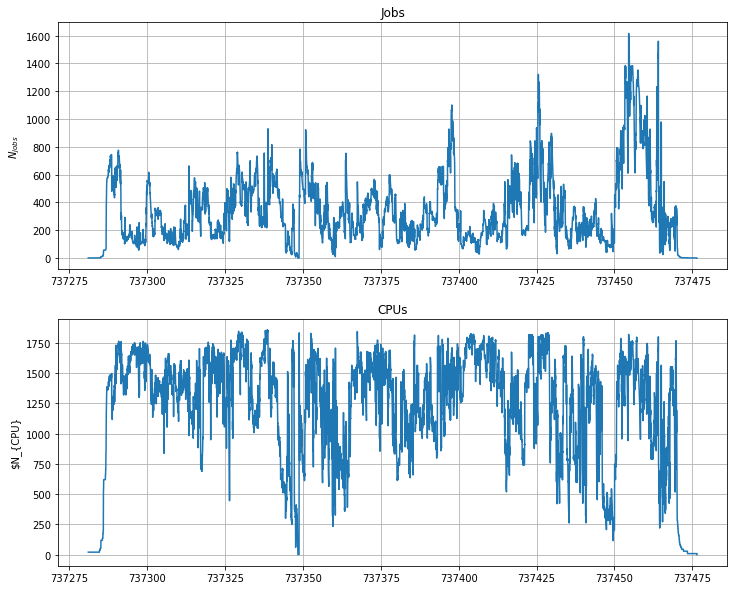

In [277]:
cpu_usage = sacct_data.active_jobs_cpu()
#cpu_usage = sacct_demo.active_jobs_cpu()

fg = plt.figure(figsize=(12,10))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
#
ax1.grid()
ax2.grid()
#
ax1.plot(cpu_usage['time'], cpu_usage['N_jobs'], ls='-')
ax2.plot(cpu_usage['time'], cpu_usage['N_cpu'], ls='-')
#
ax1.set_title('Jobs')
ax1.set_ylabel('$N_{jobs}$')
#
ax2.set_title('CPUs')
ax2.set_ylabel('$N_{CPU}')
#


In [279]:
# def get_wait_stats(self):
#     wait_stats = numpy.core.records.fromarrays(numpy.zeros((len(self.jobs_summary), 6)).T, dtype=[('ncpus', '>i8'), ('mean', '>f8'), 
#                                                                     ('median', '>f8'),  ('stdev', '>f8'),
#                                                                     ('min', '>f8'),  ('max', '>f8')])
#     #
#     delta_ts = self.jobs_summary['Start'] - self.jobs_summary['Submit']
#     #
#     for j,k in enumerate(sorted(numpy.unique(self.jobs_summary['NCPUS']) ) ):
#         #
#         x_prime = delta_ts[numpy.logical_and(self.jobs_summary['NCPUS']==k, delta_ts>=0.)]
#         #wait_stats[k-1]=[[k, numpy.mean(x_prime), numpy.median(x_prime), numpy.std(x_prime), 
#         #                 numpy.min(x_prime), numpy.max(x_prime)]]
#         #
#         #wait_stats[k-1][0] = k
#         wait_stats[j][0] = k
#         if len(x_prime)==0:
#             continue
#         #
#         for l,f in zip(range(1, 6), [numpy.mean, numpy.median, numpy.std, numpy.min, numpy.max]):
#             #
#             wait_stats[j][l]=f(x_prime)
#         #
#     #
#     return wait_stats
#
wait_stats = sacct_data.get_wait_stats()

***  0 0.5
***  1 0.8
***  2 0.95


(0, 3.0)

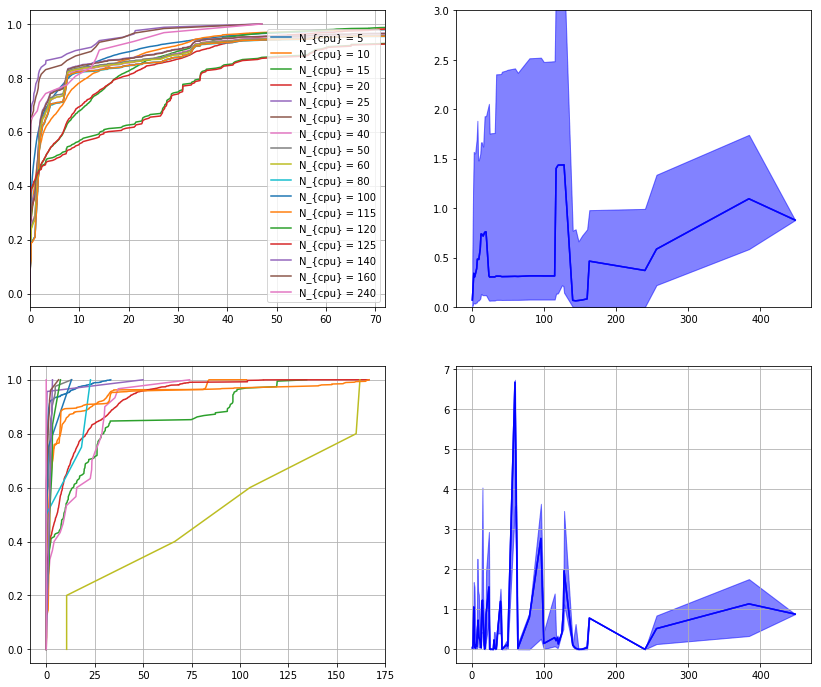

In [290]:
# Cumulative distributrions of wait times, as a function of n_cpu. Not trivially simple how we want 
#. to tell this story.
#
fg = plt.figure(figsize=(14,12))
ax1 = plt.subplot('221')
ax2 = plt.subplot('222')
#
ax3 = plt.subplot('223')
ax4 = plt.subplot('224')
#
for ax in (ax1, ax2, ax3, ax4):
    ax.grid()
#
quantiles = []
quantiles_lt = []
qs = [.5, .8, .95]

#
#len(numpy.unique(wait_stats['ncpus']))
for n in (wait_stats['ncpus']):
    if n==0: continue
    #
    
    #n = int(n)
    #X = wait_stats[wait_stats['ncpus']==n] 
    #
    xx_gt = numpy.array(sorted( (sacct_data.jobs_summary['Start'] -
                              sacct_data.jobs_summary['Submit'])[sacct_data.jobs_summary['NCPUS']>=n] ))
    xx_lt = numpy.array(sorted( (sacct_data.jobs_summary['Start'] -
                              sacct_data.jobs_summary['Submit'])[sacct_data.jobs_summary['NCPUS']==n] ))
    quantiles += [[n] + list(numpy.quantile(xx_gt, qs))]
    quantiles_lt += [[n] + list(numpy.quantile(xx_lt, qs))]
    #
    #print('*** ', n, len(xx) )
    
    #print('** {}/{}'.format(len(X), len(wait_stats)))
    #
    if n%5==0:
        ax1.plot(xx_gt*24., numpy.linspace(0., 1., len(xx_gt)), ls='-', label='N_{{cpu}} = {}'.format(n))
        #
        ax3.plot(xx_lt*24., numpy.linspace(0., 1., len(xx_lt)), ls='-', label='N_{{cpu}} = {}'.format(n))
#
quantiles = numpy.array(quantiles)
quantiles_lt = numpy.array(quantiles_lt)
#
ax1.legend(loc=0)
ax1.set_xlim(0,72)
#
#
for k,q in enumerate(qs):
    print('*** ', k,q)
    ax2.plot(quantiles[:,0], quantiles[:,2], label='$q={}$'.format(q), alpha=.7, color='b')
    ax2.fill_between(quantiles[:,0], quantiles[:,1], quantiles[:,quantiles.shape[1]-1], alpha=.2, color='b')
    #
    ax4.plot(quantiles_lt[:,0], quantiles_lt[:,2], label='$q={}$'.format(q), alpha=.7, color='b')
    ax4.fill_between(quantiles_lt[:,0], quantiles_lt[:,1],
                     quantiles_lt[:,quantiles_lt.shape[1]-1], alpha=.2, color='b')
#
ax2.grid()
ax2.set_ylim(0, 3.)

***  ['7-00:00:00' '7-00:00:00' '6-06:00:00' '2-00:00:00' '2-00:00:00'
 '2-00:00:00' '2-00:00:00' '2-00:00:00' '2-00:00:00' '2-00:00:00']
**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended')


Text(0, 0.5, 'Submit wait time, $\\Delta t_w$')

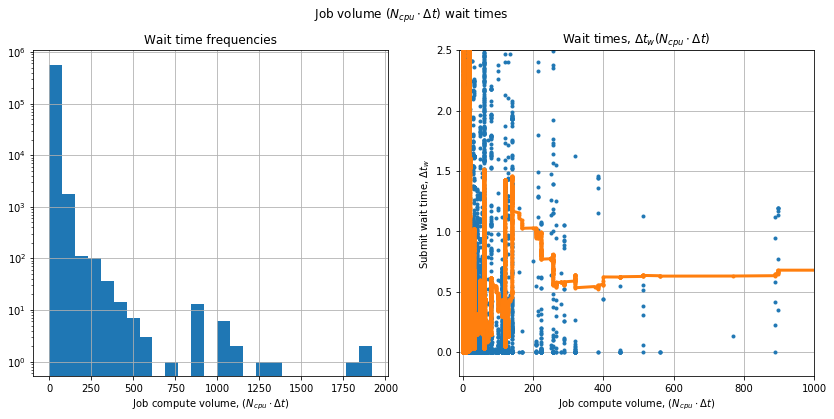

In [324]:
fg = plt.figure(figsize=(14,6))
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
ax1.grid()
ax2.grid()
#
time_limits = numpy.array([hpc_lib.elapsed_time_2_day(s) for s in sacct_data.jobs_summary['Timelimit']])
req_volume = time_limits*sacct_data.jobs_summary['NCPUS']
ix_sort = numpy.argsort(req_volume)
#
#hh = plt.hist(time_limits, 25, log=True)
hh = ax1.hist(req_volume, 25, log=True)
#
dts = sacct_data.jobs_summary['Start']-sacct_data.jobs_summary['Submit']
ax2.plot(req_volume[ix_sort], dts[ix_sort], ls='', marker='.')
n=200
ax2.plot((req_volume[ix_sort])[n:], hpc_lib.running_mean(dts[ix_sort],n), ls='-', marker='.', lw=3., zorder=11)
ax2.set_ylim([-.2, 2.5])
ax2.set_xlim(-10., 1000.)
#
print('*** ', sacct_data.jobs_summary['Timelimit'][0:10])
#print('*** ', sacct_data.data['Timelimit'][0:10])
print('** ', sacct_data.jobs_summary.dtype.names)
#
plt.suptitle('Job volume ($N_{cpu} \cdot \Delta t$) wait times')
ax1.set_title('Wait time frequencies')
ax1.set_xlabel('Job compute volume, ($N_{cpu} \cdot \Delta t$)')
ax2.set_title('Wait times, $\Delta t_w (N_{cpu} \cdot \Delta t)$')
ax2.set_xlabel('Job compute volume, ($N_{cpu} \cdot \Delta t$)')
ax2.set_ylabel('Submit wait time, $\Delta t_w$')

***  0 0.5
***  1 0.75
***  2 0.99


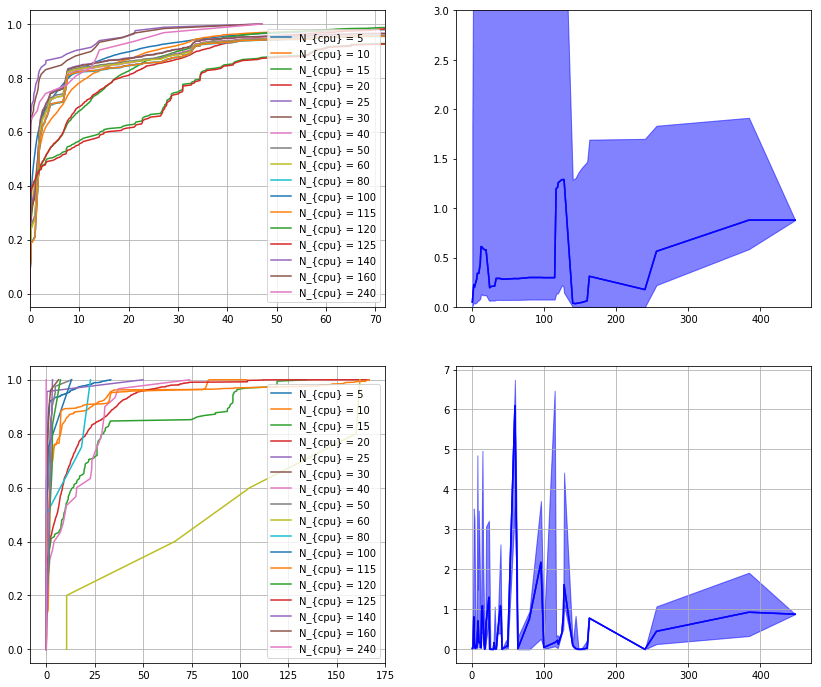

In [329]:
# Cumulative distributrions of wait times, as a function of n_cpu*run-time. Not trivially simple how we want 
#. to tell this story.
# note that this should be requested wall-time, but i'm not sure we have that.
#
fg = plt.figure(figsize=(14,12))
ax1 = plt.subplot('221')
ax2 = plt.subplot('222')
#
ax3 = plt.subplot('223')
ax4 = plt.subplot('224')
#
for ax in (ax1, ax2, ax3, ax4):
    ax.grid()
#
quantiles = []
quantiles_lt = []
qs = [.5, .75, .99]

#
#len(numpy.unique(wait_stats['ncpus']))
for n in (wait_stats['ncpus']):
    if n==0: continue
    #
    
    #n = int(n)
    #X = wait_stats[wait_stats['ncpus']==n] 
    #
    xx_gt = numpy.array(sorted( (sacct_data.jobs_summary['Start'] -
                              sacct_data.jobs_summary['Submit'])[sacct_data.jobs_summary['NCPUS']>=n] ))
    xx_lt = numpy.array(sorted( (sacct_data.jobs_summary['Start'] -
                              sacct_data.jobs_summary['Submit'])[sacct_data.jobs_summary['NCPUS']==n] ))
    quantiles += [[n] + list(numpy.quantile(xx_gt, qs))]
    quantiles_lt += [[n] + list(numpy.quantile(xx_lt, qs))]
    #
    #print('*** ', n, len(xx) )
    
    #print('** {}/{}'.format(len(X), len(wait_stats)))
    #
    if n%5==0:
        ax1.plot(xx_gt*24., numpy.linspace(0., 1., len(xx_gt)), ls='-', label='N_{{cpu}} = {}'.format(n))
        #
        ax3.plot(xx_lt*24., numpy.linspace(0., 1., len(xx_lt)), ls='-', label='N_{{cpu}} = {}'.format(n))
#
quantiles = numpy.array(quantiles)
quantiles_lt = numpy.array(quantiles_lt)
#
ax1.legend(loc=0)
ax1.set_xlim(0,72)
ax1.set_xlabel('Wait time (hours)')
#
#
for k,q in enumerate(qs):
    print('*** ', k,q)
    ax2.plot(quantiles[:,0], quantiles[:,2], label='$q={}$'.format(q), alpha=.7, color='b')
    ax2.fill_between(quantiles[:,0], quantiles[:,1], quantiles[:,quantiles.shape[1]-1], alpha=.2, color='b')
    #
    ax4.plot(quantiles_lt[:,0], quantiles_lt[:,2], label='$q={}$'.format(q), alpha=.7, color='b')
    ax4.fill_between(quantiles_lt[:,0], quantiles_lt[:,1],
                     quantiles_lt[:,quantiles_lt.shape[1]-1], alpha=.2, color='b')
#
ax2.grid()
ax2.set_ylim(0, 3.)
ax3.legend(loc=0)
ax3.set_xlabel('Wait time (hours)')

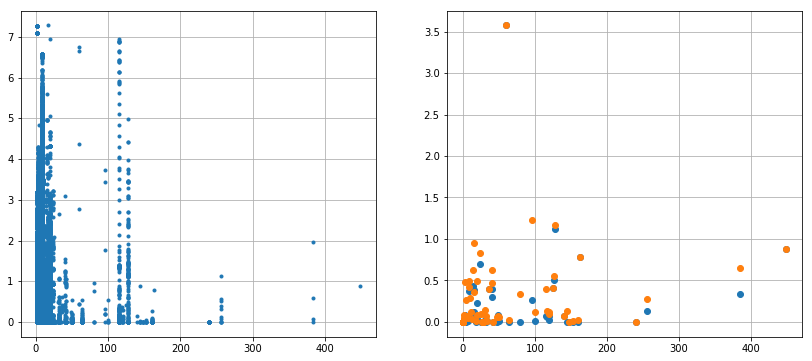

In [282]:
# def submit_wait_times(self):
#     submit_waits = self.summary_data['Start'] - self.summary_data['Submit']

X,Y = [sacct_data.jobs_summary['NCPUS'], sacct_data.jobs_summary['Start']-sacct_data.jobs_summary['Submit']]
ix = numpy.argsort(X)
#
fg = plt.figure(figsize=(14,6))
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
ax1.grid()
ax2.grid()
#
ax1.plot(X[ix], Y[ix], ls='', marker='.')
#
ax2.plot(wait_stats['ncpus'], wait_stats['median'], ls='', marker='o')
ax2.plot(wait_stats['ncpus'], wait_stats['mean'], ls='', marker='o')
ax2.set_yscale=('log')




In [196]:
print('** ', sacct_data.jobs_summary['Start'][0:20])

**  ['2019-08-14T23:09:52.000000000' '2019-08-10T00:57:02.000000000'
 '2019-08-14T21:11:53.000000000' '2019-08-14T21:17:54.000000000'
 '2019-08-14T21:17:54.000000000' '2019-08-14T21:17:54.000000000'
 '2019-08-14T21:17:54.000000000' '2019-08-14T21:17:54.000000000'
 '2019-08-14T21:17:54.000000000' '2019-08-14T21:20:11.000000000'
 '2019-08-14T21:20:11.000000000' '2019-08-14T17:26:26.000000000'
 '2019-08-14T21:20:11.000000000' '2019-08-14T21:20:11.000000000'
 '2019-08-14T21:20:11.000000000' '2019-08-14T17:26:26.000000000'
 '2019-08-14T21:20:11.000000000' '2019-08-14T21:20:11.000000000'
 '2019-08-14T21:20:11.000000000' '2019-08-14T02:04:17.000000000']


In [58]:
# unique completion states:
data_df = sacct_data.data
#
#states = sorted(list(set([rw[RH['State']]  for rw in data])))
states = sorted(list(set(data_df['State'])))
for s in states:
    print('** {}'.format(s))


** CANCELLED
** CANCELLED by 22178
** CANCELLED by 238782
** CANCELLED by 246982
** CANCELLED by 247127
** CANCELLED by 255640
** CANCELLED by 257593
** CANCELLED by 260401
** CANCELLED by 260514
** CANCELLED by 260613
** CANCELLED by 273166
** CANCELLED by 275482
** CANCELLED by 275792
** CANCELLED by 275883
** CANCELLED by 278599
** CANCELLED by 279061
** CANCELLED by 279489
** CANCELLED by 28622
** CANCELLED by 287583
** CANCELLED by 287761
** CANCELLED by 289046
** CANCELLED by 296902
** CANCELLED by 297147
** CANCELLED by 298074
** CANCELLED by 302980
** CANCELLED by 312384
** CANCELLED by 313980
** CANCELLED by 316180
** CANCELLED by 316254
** CANCELLED by 316709
** CANCELLED by 318365
** CANCELLED by 324777
** CANCELLED by 326140
** CANCELLED by 326651
** CANCELLED by 333030
** CANCELLED by 333532
** CANCELLED by 334376
** CANCELLED by 335211
** CANCELLED by 343817
** CANCELLED by 34705
** CANCELLED by 347232
** CANCELLED by 35148
** CANCELLED by 359616
** CANCELLED by 362513
**

In [ ]:
#my_groups = data_df.groupby(by=numpy.unique([s.split('.')[0] for s in data_df['JobID']]) )
#my_groups = data_df.groupby(by=[s.split('.')[0] for s in data_df['JobID']] )
ix_user_jobs = numpy.array([not ('.batch' in s or '.extern' in s) for s in data_df['JobID']])

#group_index = {s:numpy.array([]) for s in numpy.unique([s.split('.')[0] for s in data_df['JobID'][ix_user_jobs] ])}
job_ID_index = {s:[] for s in numpy.unique([s.split('.')[0] 
                                            for s in data_df['JobID'][ix_user_jobs] ])}


for k,s in enumerate(data_df['JobID']):
    job_ID_index[s.split('.')[0]] += [k]
    #group_index[s.split('.')[0]] = numpy.append(group_index[s.split('.')[0]], [k])
for ky,vl in job_ID_index.items():
    job_ID_index[ky] = numpy.array(sorted(vl))

In [ ]:
#print(data_df.dtypes)

In [ ]:
# 'Start':str2date, 'End':str2date, 'Submit':str2date, 'Elapsed'

jobs_summary = numpy.recarray(shape=(len(job_ID_index), len(sacct_data.data.dtype)), dtype=data.dtype)
for k, (j_id, ks) in enumerate(job_ID_index.items()):
    jobs_summary[k]=data_df[numpy.min(ks)]
    jobs_summary[k]['End'] = numpy.max(data_df['End'][ks])
    jobs_summary[k]['Start'] = numpy.max(data_df['Start'][ks])


In [ ]:
#print(len(my_groups))
#print('** ', my_groups.count)
#
print('** ', len(group_index))
print('** ', len(data_df['JobID']))
#
print('** ** ')

for k, (ky,vl) in enumerate(group_index.items()):
    print('* * ', ky, vl)
    if k>10: break

In [ ]:
print('** {}\n'.format(headers))
# for rw in data[0:100]:
#     if rw[RH['JobID']].split('.')[0]=='48057259_930':
#         print('** {}\n'.format(rw['Job']))
#
# this_jid = '48057259_930'
this_jid = '48693050'
this_jid = '48538697'
for rw in data:
    #print('** ', rw)
    #print('* * ', rw[RH['JobID']])
    #print('** ', rw[RH['JobID']].split('.'))
    #if rw[RH['JobID']].split('.')[0]==this_jid:
    if rw[RH['JobID']].startswith(this_jid) or rw[RH['JobID']] == this_jid:
        #print('** {}'.format(rw[RH['JobID']]))
        jid = rw[RH['JobID']]
        #jid_0, jid_1 = rw[RH['JobID']].split('_')
        # 'batch', 'extern', 
        if len(jid.split('.'))>=2 and jid.split('.')[1] in ('batch', 'extern', 'bogus_place_holder'):
            continue
        print('** {}\n'.format([rw[RH[s]] for s in ('User', 'Group', 'JobID', 'Submit', 'Timelimit',
                                  'Eligible', 'Start', 'End', 'Elapsed', 'NCPUS')]))

### Active CPUs:
- TODO: this is overcounting cpus, because there is a row for each step in the job, but each step shows the full start/stop time.
- We need to consolidate unique jobIDs.

In [ ]:
#
### how 'bout a time series of sum(ncpu) RUNNING?
#
# TODO: consider states COMPLETED, FAILED, RUNNING, TIMEOUT, PENDING. These all represent workload; only exclude
#. canceled jobs.
#ix = numpy.array([rw[RH['State']] in ['COMPLETED', 'RUNNING'] for rw in data])
#ix = numpy.logical_or( data_df['State']=='COMPLETED', data_df['State']=='RUNNING')
#ix = numpy.ones(len(data_df)).astype(bool)
ix = numpy.array(['.batch' not in s and '.extern' not in s for s in data_df['JobID']])
ix = numpy.array(['.' not in s for s in data_df['JobID']])
ix_run = numpy.array(data_df['State']!='PENDING')
ix = numpy.logical_and(ix, ix_run)
#
#
t_now = mpd.date2num(dtm.datetime.now())
t_start = mpd.date2num(data_df['Start'][ix])
#
t_end = data_df['End'][ix].to_numpy()
t_end[t_end is None]=t_now
t_end=mpd.date2num(t_end)
#
n_cpu = data_df['NCPUS'][ix].to_numpy()

start_end = numpy.array([t_start, t_end]).T
#
# sort on t_start:
start_end = start_end[numpy.argsort(start_end[:,0])]

t_min = numpy.min(numpy.append(t_start, [x for x in t_end if not x is None] ))
t_max = numpy.max(numpy.append(t_start, [x for x in t_end if not x is None] ))
#
# can also create X sequence like, for minute resolution
# X = numpy.arange(t_min, t_max, 1./(24*60))
X = numpy.linspace(t_min, t_max, 10000)
#
Ns = numpy.zeros(len(X))
#
Ns_cpu = numpy.zeros(len(X))

In [ ]:
# this is many 100's of times faster than its cousin below:
#Ns2 = numpy.zeros(len(X))
#
for j, (t_1, t_2, n) in enumerate(zip(t_start, t_end, n_cpu)):
    #if j%25000==0:
    #    print('j:: {}'.format(j))
    #
    # TODO: get more of the data set; we appear to be counting more cpus than exist?
    # 1) check partition info, 2) maybe we're creating some sort of sampling error?
    #.
    ix = numpy.logical_and( X>=t_1, X<t_2)
    Ns[ix] += 1
    Ns_cpu[ix] += n
    #

In [ ]:
x1 = numpy.random.random(10)
x2 = numpy.random.random(10)
#
print('x1: ', x1)
print('x2: ', x2)

In [ ]:
# let's try another, should be more compute efficint way of computing running jobs/cpus:
#. compute a sequence of started_jobs and a sequence of ended_jobs, then subtract.
# to do the subtraction, interpolate onto a common time-axis.
#
# TODO: this general strategy is probably smarter for creating these working arrays, but for now just
#. use th eexisting working arrays.
# ix_active = numpy.logical_or(data_df['State']=='COMPLETED', data_df['State']=='RUNNING')
# #
# starts = numpy.array([(mpd.date2num(data_df[ix_active])['Start']), (data_df[ix_active])['NCPUS']])
# #starts.sor
# stops  = numpy.array([(mpd.date2num(data_df[ix_active])['End']), (data_df[ix_active])['NCPUS']])
#
import scipy.interpolate
#
ix_start = numpy.argsort(t_start)
ix_end   = numpy.argsort(t_end)
#
ns_start = numpy.array([t_start[ix_start], numpy.cumsum(n_cpu[ix_start])])
ns_end   = numpy.array([t_end[ix_end], numpy.cumsum(n_cpu[ix_end])])
#
f_start = scipy.interpolate.interp1d(ns_start[0], ns_start[1], fill_value="extrapolate", bounds_error=False)
f_end   = scipy.interpolate.interp1d(ns_end[0], ns_end[1], fill_value="extrapolate")


In [ ]:
fg = plt.figure(figsize=(12, 10))
ax1 = plt.subplot('211')
ax1.grid()
#
ax2 = plt.subplot('223')
ax2.grid()
ax2.set_title('cpu starts')
#
ax3 = plt.subplot('224')
ax3.grid()
ax3.set_title('cpu completes')
#
#
ax2.plot(*ns_start, ls='-', marker='')
ax3.plot(*ns_end, ls='-', marker='')
#
X = numpy.linspace(numpy.min(numpy.array([t_start[ix_start], t_end[ix_end]])),
                       numpy.max(numpy.array([t_start[ix_start], t_end[ix_end]])), 10000)
ax2.plot(X, f_start(X), ls='--')
ax3.plot(X, f_end(X), ls='--')
#

ax1.plot(X[:-1000], (f_start(X)-f_end(X))[:-1000], ls='-')
ax1.set_title('Active CPUs')

In [ ]:
fg = plt.figure(figsize=(12,10))
ax1 = plt.subplot('311')
ax2 = plt.subplot('312', sharex=ax1)
ax3 = plt.subplot('313', sharex=ax1)
n_ave = 100
#
ln, = ax1.plot(X,Ns, ls='-', lw=1.5, marker='', alpha=.3)
clr = ln.get_color()
#
Ns_sm = (numpy.cumsum(Ns)[n_ave:]-numpy.cumsum(Ns)[:-n_ave])/float(n_ave)
ax1.plot(X[n_ave:], Ns_sm, color=clr,
        ls='--', lw=2.)

ln, = ax2.plot(X, Ns_cpu, ls='-', lw=3., marker='', alpha=.3)
clr = ln.get_color()
Ns_cpu_sm = (numpy.cumsum(Ns_cpu)[n_ave:]-numpy.cumsum(Ns_cpu)[:-n_ave])/float(n_ave)
ax2.plot(X[n_ave:], Ns_cpu_sm, color=clr,
        ls='--', lw=2.)

ax3.plot(X[n_ave:], Ns_cpu_sm/Ns_sm, color=clr,
        ls='--', lw=2.)

#
ax1.set_title('jobs running')
ax2.set_title('cpu running')
ax3.set_title('cpu/job')
#
ax1.grid()
ax2.grid()
ax3.grid()

In [ ]:
86*24

In [ ]:

#
# delta_ts_all = numpy.array([elapsed_time_2_sec(rw[RH['Elapsed']]) for rw in data])
# delta_ts_completed = numpy.array([elapsed_time_2_sec(rw[RH['Elapsed']]) 
#                                   for rw in data if rw[RH['State']]=='COMPLETED'])
#
delta_ts_all = numpy.array([rw[RH['Elapsed']] for rw in data])
delta_ts_completed = numpy.array([rw[RH['Elapsed']] 
                                  for rw in data if rw[RH['State']]=='COMPLETED'])
#
print('*** lens: {}, {}'.format(len(delta_ts_all), len(delta_ts_completed)))
#
print(delta_ts_all[0:10])
#
fg = plt.figure(figsize=(12,10))
ax = plt.subplot('111')
#
do_normed = True
do_log    = False
do_cum    = True
h_type  = 'step'
time_factor=1.0/(24.*3600)
#
hh_all  = ax.hist(delta_ts_all*time_factor, bins=50, log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed,
                  label='all jobs')
hh_comp = ax.hist(delta_ts_completed*time_factor, bins=50, log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed, 
                  label='completed')
#
ax.legend(loc=0)
#
ax.set_ylim(.99,1.001)

In [ ]:
# time delayed plots. aka, probability (or counts) of job times given jobs > t_min
#
fg = plt.figure(figsize=(12,10))
ax = plt.subplot('111')
#
do_normed = False
do_log    = False
do_cum    = True
h_type  = 'step'
time_factor=1.0/(24.*3600)
#
delta_ts_completed = numpy.array([rw[RH['Elapsed']]
                                      for rw in data if rw[RH['State']]=='COMPLETED'])
for k,t_min in enumerate([0., 3600., 36000., 24.*3600, 5.*24.*3600, 7.*24.*3600]):
    if k<2: continue

    #delta_ts_all = numpy.array([elapsed_time_2_sec(rw[RH['Elapsed']]) for rw in data])
    
    #
    #print('*** lens: {}, {}'.format(len(delta_ts_all), len(delta_ts_completed)))
    #
    #print(delta_ts[0:10])
    #
    #
    #hh_all  = ax.hist(delta_ts_all*time_factor, bins=50, log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed,
    #                  label='all jobs')
    Y,X, patches = ax.hist(delta_ts_completed[delta_ts_completed>= t_min]*time_factor, bins=50,
                           log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed, 
                      label='$t_{{min}}={}'.format(t_min*time_factor,))
    #
    # fill bewteen (approximate) dt=7 intersection and y.
    k0 = numpy.argmin( (X-7.)**2. )
    y0 = Y[k0]
    clr = patches[0].get_edgecolor()
    ix = X[:-1]>7.
    #
    X_prime = [X[k0]]
    Y_prime = [Y[k0]]
    for j, (x,y1,y2) in enumerate(zip(X[k0+1:], Y[k0:-1], Y[k0+1:])):
        X_prime += [x, x]
        Y_prime += [y1, y2]
    #
    #ax.fill_between(numpy.array(X[:-1])[ix], y0, Y[ix], color=clr, alpha=.1)
    ax.fill_between(X_prime, y0, Y_prime, color=clr, alpha=.1)
    #print('** ** ', len(ax.lines))
    #
ax.legend(loc=0)
ax.grid()
ax.plot([7., 7.], ax.get_ylim(), marker='.', ls='--', lw=2., color='m')
ax.plot(ax.get_xlim(), [.9, .9], marker='', ls='--', lw=2., color='m')
#
ax.set_title('Cumulative Distribution of Job Lengths')

In [ ]:
# time delayed plots. aka, probability (or counts) of job times given jobs > t_min
#
fg = plt.figure(figsize=(12,10))
ax = plt.subplot('111')
#
do_normed = False
do_log    = False
do_cum    = True
h_type  = 'step'
time_factor=1.0/(24.*3600)
#
# usage index: dt*ncpus
usage_index_completed = numpy.array([rw[RH['Elapsed']]*float(rw[RH['NCPUS']])
                                      for rw in data if rw[RH['State']]=='COMPLETED'])
for k,t_min in enumerate([0., 3600., 36000., 24.*3600, 5.*24.*3600, 7.*24.*3600]):
    if k<1: continue

    #delta_ts_all = numpy.array([elapsed_time_2_sec(rw[RH['Elapsed']]) for rw in data])
    
    #
    #print('*** lens: {}, {}'.format(len(delta_ts_all), len(delta_ts_completed)))
    #
    #print(delta_ts[0:10])
    #
    #
    #hh_all  = ax.hist(delta_ts_all*time_factor, bins=50, log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed,
    #                  label='all jobs')
    Y,X, patches = ax.hist(usage_index_completed[delta_ts_completed>= t_min]*time_factor, bins=50,
                           log=do_log, cumulative=do_cum, histtype=h_type, normed=do_normed, 
                      label='$t_{{min}}={}$'.format(t_min*time_factor,))
    #
    # fill bewteen (approximate) dt=7 intersection and y.
    k0 = numpy.argmin( (X-7.)**2. )
    y0 = Y[k0]
    clr = patches[0].get_edgecolor()
    ix = X[:-1]>7.
    #
    X_prime = [X[k0]]
    Y_prime = [Y[k0]]
    for j, (x,y1,y2) in enumerate(zip(X[k0+1:], Y[k0:-1], Y[k0+1:])):
        X_prime += [x, x]
        Y_prime += [y1, y2]
    #
    #ax.fill_between(numpy.array(X[:-1])[ix], y0, Y[ix], color=clr, alpha=.1)
    ax.fill_between(X_prime, y0, Y_prime, color=clr, alpha=.1)
    #print('** ** ', len(ax.lines))
    #
ax.legend(loc=0)
ax.grid()
ax.plot([7., 7.], ax.get_ylim(), marker='.', ls='--', lw=2., color='m')
ax.plot(ax.get_xlim(), [.9, .9], marker='', ls='--', lw=2., color='m')
#
ax.set_title('Cumulative Distribution of Usage-index ($\Delta t \cdot N_{cpu}$)')

In [ ]:
# How 'bout some data on long jobs...
#
long_jobs = [rw for rw in data if rw[RH['Elapsed']]>7*24.*3600]
#
long_jobs_df = data_df[data_df['Elapsed']>7*24.*3600]
#

In [ ]:
# partitions using long jobs:
print("Long Job Partitons: ")
print("len: ", len(long_jobs))
print('partitions: ')
#for rw in list(set([s[RH['Partition']] for s in long_jobs])):
for rw in list(set(long_jobs_df['Partition'])):
    print('** ', rw)
    #
#
# partitions using long jobs:
print("Long Job Users: ")
print("len: ", len(long_jobs))
print('Users: ')
for rw in list(set(long_jobs_df['User'])):
    print('** ', rw)
    #
#

In [ ]:
print(headers)

In [ ]:
total_compute_vol = numpy.sum(data_df['NCPUS']*data_df['Elapsed'])
ix = data_df['Elapsed']>(7.*24.*3600.)
long_compute_vol = numpy.sum(data_df['NCPUS'][ix]*data_df['Elapsed'][ix])
#
print('** jobs: ', len(data), len(data_df[ix]), sum(ix), len(data_df[ix])/len(data))
print('** compute tinme: ', numpy.sum(data_df['Elapsed']), numpy.sum(data_df['Elapsed'][ix]),
      numpy.sum(data_df['Elapsed'][ix])/numpy.sum(data_df['Elapsed']))
print('** compute volumnes: ', total_compute_vol, long_compute_vol, long_compute_vol/total_compute_vol)


In [ ]:
#
ts = numpy.arange(1,40)
lcvs = numpy.zeros(len(ts))
mean_n_cpus = numpy.zeros(len(ts))
stdev_n_cpus = numpy.zeros(len(ts))
max_n_cpus = numpy.zeros(len(ts))
median_n_cpus = numpy.zeros(len(ts))

for k,t in enumerate(ts):
    ix = data_df['Elapsed']>(t*24.*3600.)
    lcv = numpy.sum(data_df['NCPUS'][ix]*data_df['Elapsed'][ix])
    #
    lcvs[k] = numpy.sum(numpy.sum(data_df['NCPUS'][ix]*data_df['Elapsed'][ix]))/total_compute_vol
    #
    mean_n_cpus[k]  = numpy.mean(data_df['NCPUS'][ix])
    stdev_n_cpus[k] = numpy.std(data_df['NCPUS'][ix])
    max_n_cpus[k] = numpy.max(data_df['NCPUS'][ix])
    median_n_cpus[k] = numpy.median(data_df['NCPUS'][ix])
    #
#
fg = plt.figure(figsize=(12,10))
ax1 = plt.subplot('211')
ax1.grid()
ax2 = plt.subplot('212')
ax2.grid()
#
ax1.plot(ts, lcvs, ls='-', marker='o', lw=3)
ln, ax2.plot(ts, mean_n_cpus, ls='-', marker='o', lw=3)
clr = ln.get_color()
ax2.fill_between(ts, numpy.max([numpy.ones(len(ts)), mean_n_cpus-stdev_n_cpus], axis=0), mean_n_cpus+stdev_n_cpus, alpha=.2, color=clr)
ax2.plot(ts, max_n_cpus, ls='--', marker='.', lw=2., alpha=.5)
ax2.plot(ts, median_n_cpus, ls='--', marker='.', lw=2., alpha=.7, color=clr)
#
#
n = 7
ax1.plot([0., n], [lcvs[n-1], lcvs[n-1]], ls='--', lw=2., color='b')
ax1.plot([n, n], [0., lcvs[n-1]], ls='--', lw=2., color='b')
#
n=14
ax1.plot([0., n], [lcvs[n-1], lcvs[n-1]], ls='--', lw=2., color='c')
ax1.plot([n, n], [0., lcvs[n-1]], ls='--', lw=2., color='c')
#
ax1.set_ylim(-.01, .3)
#
ax1.set_title('Fraction of jobs $\Delta t > t$')
ax1.set_ylabel('Fraction of long jobs')
ax1.set_xlabel('Job length $t$ [days]')

ax2.set_title('Number of CPU cores')
ax2.set_ylabel('Number of CPUs $N_{cpu}$')
ax2.set_xlabel('Job length $t$ [days]')



### Job wait times
- Compute stats (mean, median, stdev) for wait times, as a function of the number of cores, $n_{cpu}$


In [ ]:
# Wait times as a funciton of CPU.
#
delta_ts = mpd.date2num(data_df['Start']) - mpd.date2num(data_df['Submit'])
#
# do some binning and stats:
#Ns_cpus = numpy.unique(dat_df['NCPUS'])
Ns_cpu = numpy.arange(max(data_df['NCPUS']))+1
# so we could spin through this and group all the data into bins, like:
# 1: (x10, x11, x12..), 2:(x20, x21, x22...)
# ... or we could sort the data and use a find_in_sorted() type function, but for
#. now, i think it will be sufficient to just spin through the list a few times and use an index:
#
wait_stats = numpy.core.records.fromarrays(numpy.zeros((len(Ns_cpu), 6)).T, dtype=[('n', '>f8'), ('mean', '>f8'), 
                                                                ('median', '>f8'),  ('stdev', '>f8'),
                                                                ('min', '>f8'),  ('max', '>f8')])
#
for k in Ns_cpu:
    #x_prime = delta_ts[data_df['NCPUS']==k]
    x_prime = delta_ts[numpy.logical_and(data_df['NCPUS']==k, delta_ts>=0.)]
    #wait_stats[k-1]=[[k, numpy.mean(x_prime), numpy.median(x_prime), numpy.std(x_prime), 
    #                 numpy.min(x_prime), numpy.max(x_prime)]]
    wait_stats[k-1][0] = k
    if len(x_prime)==0:
        continue
    
    for j,f in zip(range(1, 6), [numpy.mean, numpy.median, numpy.std, numpy.min, numpy.max]):
        #
        wait_stats[k-1][j]=f(x_prime)
#

In [ ]:

print('** ', 1./(24*60) )
print('** ', .0007*24.*60)

In [ ]:
#
# make a step-function of median wait times:
#step_meds = [[0,0]]
step_meds=[]
for x,y in zip(Ns_cpu, wait_stats['median']):
    #x0 = step_meds[-1][0]
    step_meds += [[x-1, 0], [x-1, y], [x,y], [x,0]]
step_meds = numpy.array(step_meds)
#
fg = plt.figure(figsize=(12,8))
ax1 = plt.subplot('211')
#ax1 = plt.subplot('111')
ax2 = plt.subplot('212', sharex=ax1)
#
#ln, = ax1.plot(Ns_cpu, wait_stats['mean'])
clr = ln.get_color()
#ax1.plot(Ns_cpu, wait_stats['median'], color=clr, ls='-')
#ax1.plot(Ns_cpu, wait_stats['mean'], color=None, ls='--')
#ax1.fill_between(Ns_cpu, wait_stats['median'], wait_stats['median']+wait_stats['stdev'], color=clr, alpha=.2)
ax1.plot(*step_meds.T, ls='-', marker='')
#
ix = wait_stats['mean']>0.
ln2, = ax2.plot(Ns_cpu[ix], 24.*wait_stats['median'][ix], marker='.', ls='-')
clr2=ln2.get_color()
#
ix = wait_stats['mean']>0.
ax2.errorbar((Ns_cpu)[ix], 24.*(wait_stats['median'])[ix], 24.*(wait_stats['stdev'])[ix],
             color=clr2, ls='', alpha=.2)
#
#ax2.plot(data_df['NCPUS'], delta_ts, ls='', marker='.')
#
ax1.grid()
ax1.set_xlabel('Number of Cores $N_{cpu}$')
ax1.set_ylabel('Wait time to start (in days)')
#ax1.set_ylim(0., .0005)
ax1.set_yscale('log')
#ax2.set_yscale('log')
#
ax2.set_ylim(-.2, 6.0)
ax2.grid()
ax2.set_ylabel('wait time, hours')

In [ ]:
data_sorted = pandas.DataFrame(sorted(sacct_data.data, key=lambda rw: rw[sacct_data.RH['JobID']]), columns=active_headers) 

In [ ]:
ix = ['.' in s and not ( '.batch' in s or '.extern' in s) for s in data_sorted['JobID']]
print('** :\n', (data_sorted.iloc[ix, [RH[s] 
                                        for s in ['JobName', 'JobID', 'JobIDRaw',
                                                  'Elapsed']]])[0:20] )
# , 'CPUTimeRAW'

In [ ]:
#ix = numpy.array([s.startswith('48057259') 
ix = numpy.array(['48270204' in s 
                                         and not ('.batch' in s 
                                         or '.extern' in s) for s in data_sorted['JobID']])

print(data_sorted['JobID'][ix])
#print(data_sorted['JobID'][ numpy.array(['48057259' in s for s in data_sorted['JobID']])])

In [ ]:
print(data_sorted.loc[ix, ['JobID','NCPUS', 'Start', 'End', 'Elapsed','TotalCPU', 'State'] ] )